In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib

import seaborn as sns

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


To download the CIFAR-10 dataset, convert the images to tensors, and create data loaders for training and testing with batch processing and multithreading support.

In [6]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:05<00:00, 29.9MB/s]


# Neural Network Model Features
### (based on tasks)
Uses convolutional layers in the encoder for effective feature extraction.

Decoder employs ConvTranspose2D layers to reconstruct images from latent space.

Trained using Mean Squared Error (MSE) loss for pixel-wise reconstruction accuracy.

## Additional applications based on our *observations*

Learns a compressed latent representation of the input images.

Capable of denoising when trained or tested with noisy data.

End-to-end trainable with the Adam optimizer for efficient convergence.

Maintains spatial structure through padding and stride settings in both encoder and decoder.

define and train a convolutional autoencoder on the CIFAR-10 dataset for 20 epochs using mean squared error loss. The model learns to reconstruct input images by encoding them into a lower-dimensional latent space and decoding them back to the original image.

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, output_padding=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
train_loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        outputs, _ = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(trainloader)
    train_loss_list.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.0164
Epoch [2/20], Loss: 0.0066
Epoch [3/20], Loss: 0.0051
Epoch [4/20], Loss: 0.0042
Epoch [5/20], Loss: 0.0036
Epoch [6/20], Loss: 0.0032
Epoch [7/20], Loss: 0.0028
Epoch [8/20], Loss: 0.0026
Epoch [9/20], Loss: 0.0023
Epoch [10/20], Loss: 0.0021
Epoch [11/20], Loss: 0.0020
Epoch [12/20], Loss: 0.0018
Epoch [13/20], Loss: 0.0018
Epoch [14/20], Loss: 0.0017
Epoch [15/20], Loss: 0.0016
Epoch [16/20], Loss: 0.0015
Epoch [17/20], Loss: 0.0015
Epoch [18/20], Loss: 0.0014
Epoch [19/20], Loss: 0.0014
Epoch [20/20], Loss: 0.0013


# Training Loss v/s Epochs    

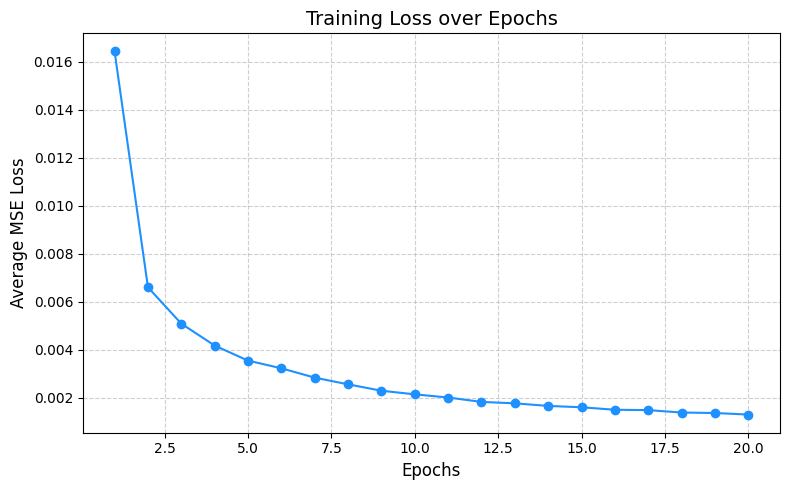

In [8]:
# import matplotlib.pyplot as plt

# Plot average MSE loss per epoch from above data
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, marker='o', color='dodgerblue')
plt.title("Training Loss over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Average MSE Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Model Structure visualization

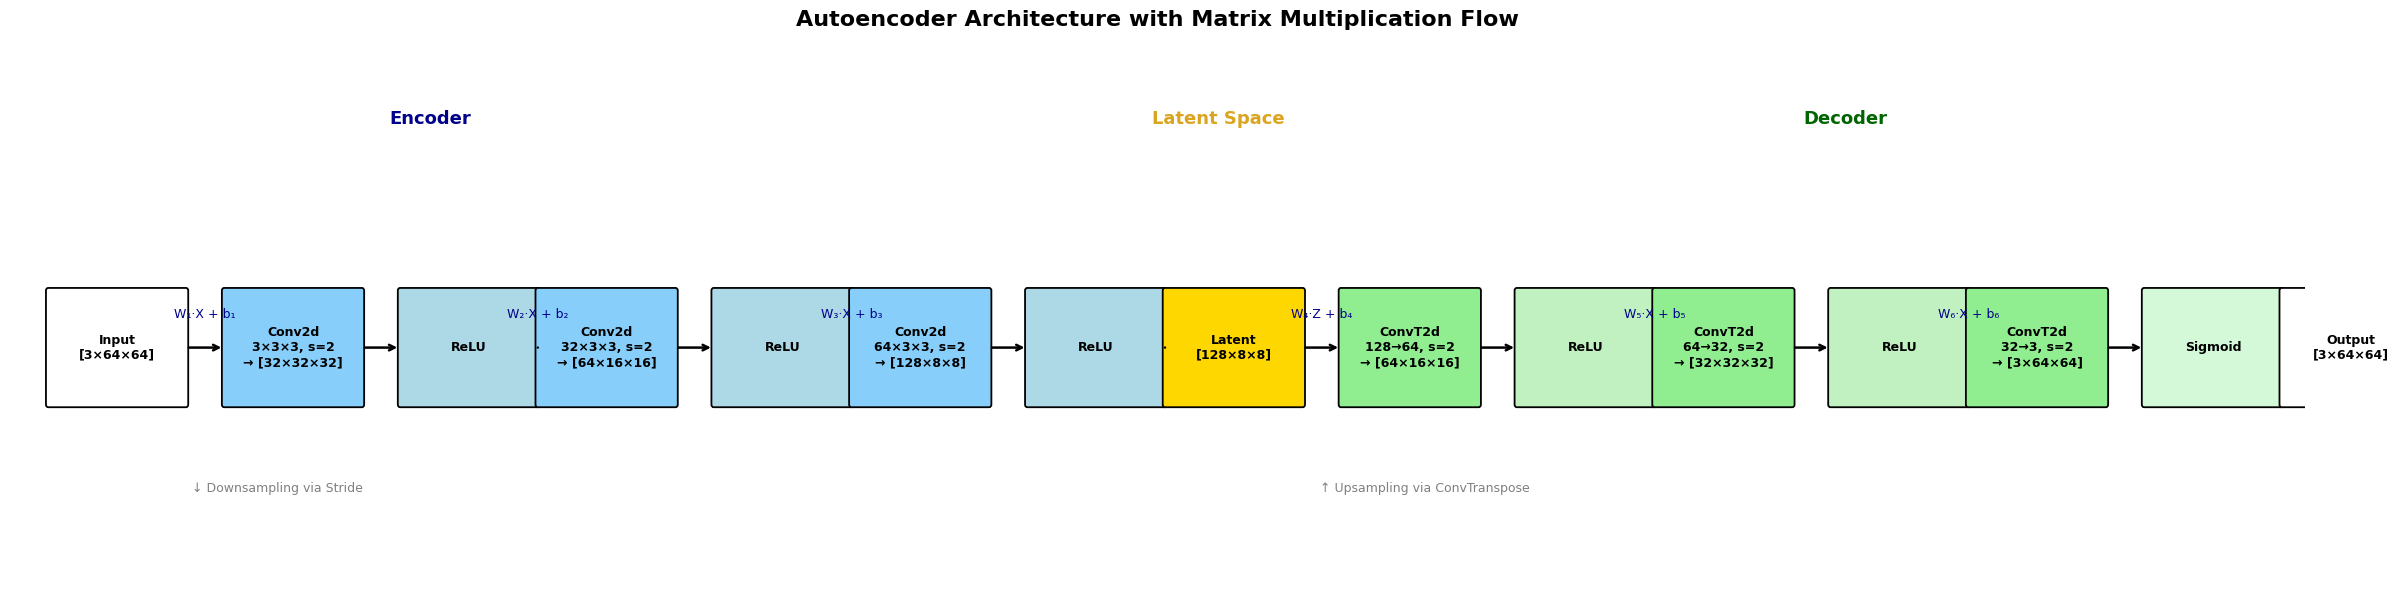

In [9]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

def draw_block(ax, x, y, w, h, label, color='lightgray'):
    rect = patches.FancyBboxPatch((x, y), w, h,
                                   boxstyle="round,pad=0.03",
                                   linewidth=1.3,
                                   edgecolor='black',
                                   facecolor=color)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, label, ha='center', va='center', fontsize=9, weight='bold')

def draw_autoencoder_with_multiplication():
    fig, ax = plt.subplots(figsize=(24, 6))
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 6)
    ax.axis('off')

    # Define layers: (label, x-pos, color)
    layers = [
        ("Input\n[3×64×64]", 0.5, '#ffffff'),
        ("Conv2d\n3×3×3, s=2\n→ [32×32×32]", 2.8, '#87CEFA'),
        ("ReLU", 5.1, '#add8e6'),
        ("Conv2d\n32×3×3, s=2\n→ [64×16×16]", 6.9, '#87CEFA'),
        ("ReLU", 9.2, '#add8e6'),
        ("Conv2d\n64×3×3, s=2\n→ [128×8×8]", 11.0, '#87CEFA'),
        ("ReLU", 13.3, '#add8e6'),
        ("Latent\n[128×8×8]", 15.1, '#FFD700'),
        ("ConvT2d\n128→64, s=2\n→ [64×16×16]", 17.4, '#90EE90'),
        ("ReLU", 19.7, '#c1f0c1'),
        ("ConvT2d\n64→32, s=2\n→ [32×32×32]", 21.5, '#90EE90'),
        ("ReLU", 23.8, '#c1f0c1'),
        ("ConvT2d\n32→3, s=2\n→ [3×64×64]", 25.6, '#90EE90'),
        ("Sigmoid", 27.9, '#d3f9d8'),
        ("Output\n[3×64×64]", 29.7, '#ffffff'),
    ]

    # Draw blocks
    for label, x, color in layers:
        draw_block(ax, x, 2, 1.8, 1.3, label, color)

    # Draw arrows with matrix multiplication annotations
    matrix_labels = ["W₁·X + b₁", "", "W₂·X + b₂", "", "W₃·X + b₃", "", "", "W₄·Z + b₄", "", "W₅·X + b₅", "", "W₆·X + b₆", "", ""]

    for i in range(len(layers) - 1):
        x_start = layers[i][1] + 1.8
        x_end = layers[i + 1][1]
        y = 2.65

        # Arrow
        ax.annotate("",
                    xy=(x_end, y),
                    xytext=(x_start, y),
                    arrowprops=dict(arrowstyle="->", lw=1.8, color='black'))

        # Matrix label
        if matrix_labels[i]:
            ax.text((x_start + x_end) / 2, y + 0.3, matrix_labels[i], fontsize=9, ha='center', va='bottom', color='darkblue')

    # Section titles
    ax.text(5.5, 5.2, "Encoder", fontsize=13, weight='bold', ha='center', color="#00008B")
    ax.text(15.8, 5.2, "Latent Space", fontsize=13, weight='bold', ha='center', color="#DAA520")
    ax.text(24.0, 5.2, "Decoder", fontsize=13, weight='bold', ha='center', color="#006400")

    # Extra notes
    ax.text(3.5, 1.0, "↓ Downsampling via Stride", fontsize=9, color='gray', ha='center')
    ax.text(18.5, 1.0, "↑ Upsampling via ConvTranspose", fontsize=9, color='gray', ha='center')

    plt.title("Autoencoder Architecture with Matrix Multiplication Flow", fontsize=16, weight='bold', pad=20)
    plt.tight_layout()
    plt.show()

draw_autoencoder_with_multiplication()


visualize and compare original, latent, and reconstructed images from the trained autoencoder on CIFAR-10 test data. It displays a few examples side by side to show how well the autoencoder compresses and reconstructs image data

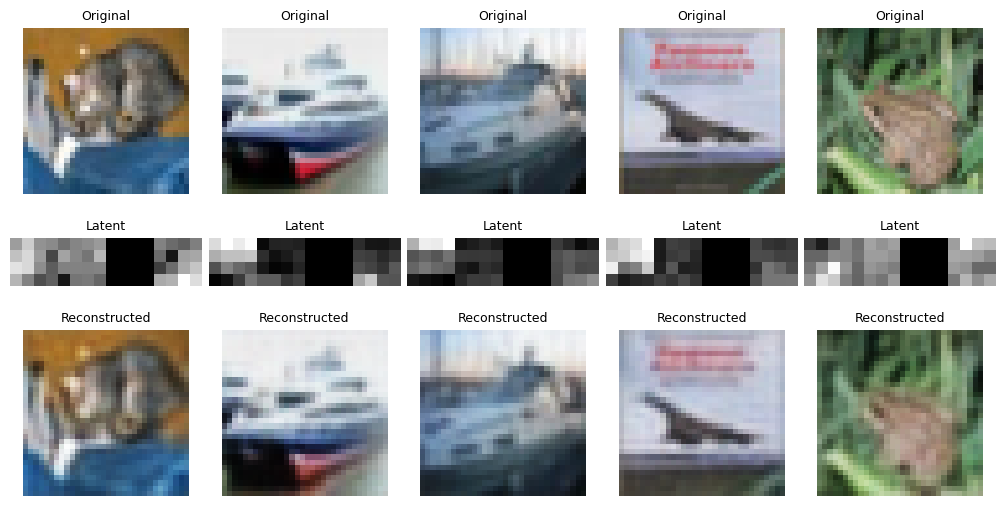

In [10]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

def show_images_with_latent(original, latent, reconstructed, n=5, latent_channels=4):
    plt.figure(figsize=(10, 5))  # Adjusted size for 5 images

    for i in range(n):
        # Original
        plt.subplot(3, n, i + 1)
        plt.imshow(np.transpose(original[i], (1, 2, 0)))
        plt.title("Original", fontsize=9)
        plt.axis("off")

        # Latent Space (first few channels side-by-side)
        latent_img = latent[i, :latent_channels].cpu().numpy()
        grid = np.concatenate([latent_img[j] for j in range(latent_channels)], axis=1)
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(grid, cmap='gray')
        plt.title("Latent", fontsize=9)
        plt.axis("off")

        # Reconstructed
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        plt.title("Reconstructed", fontsize=9)
        plt.axis("off")

    plt.tight_layout(pad=0.5)
    plt.show()

# Run inference
model.eval()
with torch.no_grad():
    for data in testloader:
        imgs, _ = data
        imgs = imgs.to(device)
        recon, latent = model(imgs)
        break

# Display 5 images
show_images_with_latent(imgs.cpu(), latent.cpu(), recon.cpu(), n=5)


#Model Evaluation

In [11]:
def evaluate_metrics(original, reconstructed):
    original = original.permute(0, 2, 3, 1).cpu().numpy()
    reconstructed = reconstructed.permute(0, 2, 3, 1).cpu().numpy()

    ssim_list, psnr_list, mae_list, mse_list = [], [], [], []

    for i in range(original.shape[0]):
        orig_img = original[i]
        recon_img = reconstructed[i]
        ssim_list.append(ssim(orig_img, recon_img, channel_axis=-1, data_range=1.0))
        psnr_list.append(psnr(orig_img, recon_img, data_range=1.0))
        mae_list.append(np.abs(orig_img - recon_img).mean())
        mse_list.append(np.square(orig_img - recon_img).mean())

    print(f"SSIM: {np.mean(ssim_list):.4f}")
    print(f"PSNR: {np.mean(psnr_list):.2f} dB")
    print(f"MAE: {np.mean(mae_list):.4f}")
    print(f"MSE: {np.mean(mse_list):.4f}")
evaluate_metrics(imgs, recon)

SSIM: 0.9425
PSNR: 29.76 dB
MAE: 0.0250
MSE: 0.0013


# noise latent space in principle component analysis

visualize the effect of noise on the latent representations learned by the autoencoder. It uses PCA to reduce the latent vectors (from clean and noisy CIFAR-10 inputs) to 2D and plots them to compare how well the latent space preserves class separability under noise.

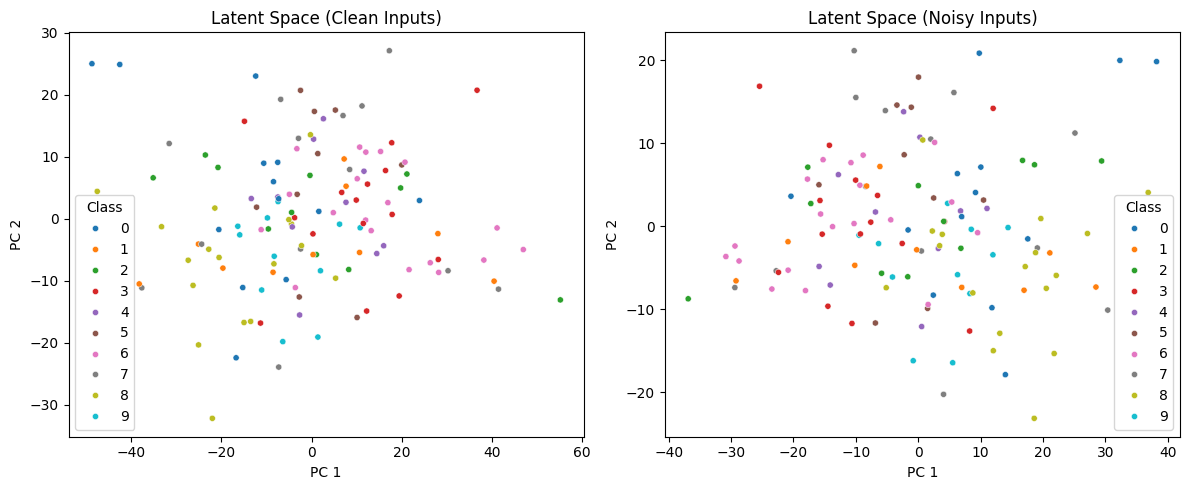

In [12]:
# import torch
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import seaborn as sns

# 1. Get a batch of test images
model.eval()
with torch.no_grad():
    for imgs, labels in testloader:
        imgs = imgs.to(device)
        break

# 2. Create noisy versions
noise_factor = 0.3
noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

# 3. Pass through encoder
with torch.no_grad():
    _, latent_clean = model(imgs)
    _, latent_noisy = model(noisy_imgs)

# 4. Flatten the latent vectors
latent_clean_flat = latent_clean.view(latent_clean.size(0), -1).cpu().numpy()
latent_noisy_flat = latent_noisy.view(latent_noisy.size(0), -1).cpu().numpy()

# 5. Reduce to 2D using PCA
pca = PCA(n_components=2)
latent_clean_2d = pca.fit_transform(latent_clean_flat)
latent_noisy_2d = pca.fit_transform(latent_noisy_flat)

# 6. Plot
plt.figure(figsize=(12, 5))

# Clean latent space
plt.subplot(1, 2, 1)
sns.scatterplot(x=latent_clean_2d[:, 0], y=latent_clean_2d[:, 1], hue=labels.cpu().numpy(), palette='tab10', s=20)
plt.title("Latent Space (Clean Inputs)")
plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.legend(title="Class", loc='best')

# Noisy latent space
plt.subplot(1, 2, 2)
sns.scatterplot(x=latent_noisy_2d[:, 0], y=latent_noisy_2d[:, 1], hue=labels.cpu().numpy(), palette='tab10', s=20)
plt.title("Latent Space (Noisy Inputs)")
plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.legend(title="Class", loc='best')

plt.tight_layout()
plt.show()


To visually compare the effect of noise on image reconstruction and latent representations in an autoencoder. It shows original, noisy, clean/noisy latent encodings, and reconstructions side-by-side for better understanding of the autoencoder’s robustness to noise.

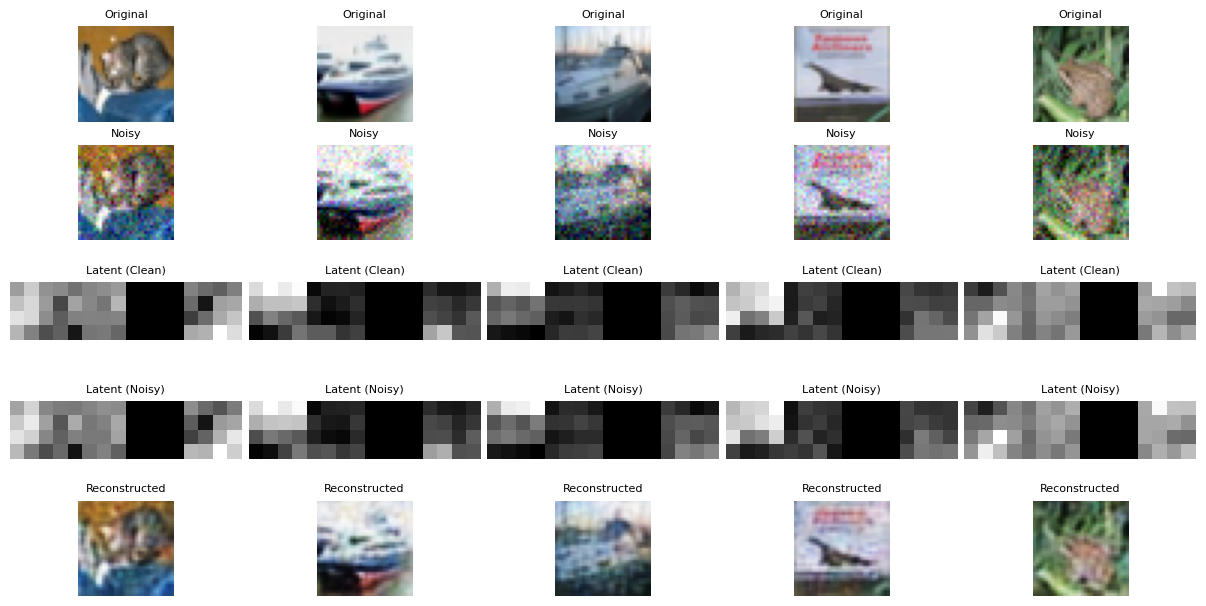

In [13]:
def show_images_with_latents_comparison(original, noisy, latent_clean, latent_noisy, reconstructed_clean, reconstructed_noisy, n=5, latent_channels=4):
    plt.figure(figsize=(12, 6))

    for i in range(n):
        # Original (clean input)
        plt.subplot(5, n, i + 1)
        plt.imshow(np.transpose(original[i], (1, 2, 0)))
        plt.title("Original", fontsize=8)
        plt.axis("off")

        # Noisy input
        plt.subplot(5, n, i + 1 + n)
        plt.imshow(np.transpose(noisy[i], (1, 2, 0)))
        plt.title("Noisy", fontsize=8)
        plt.axis("off")

        # Latent (clean)
        latent_img_clean = latent_clean[i, :latent_channels].cpu().numpy()
        grid_clean = np.concatenate([latent_img_clean[j] for j in range(latent_channels)], axis=1)
        plt.subplot(5, n, i + 1 + 2 * n)
        plt.imshow(grid_clean, cmap='gray')
        plt.title("Latent (Clean)", fontsize=8)
        plt.axis("off")

        # Latent (noisy)
        latent_img_noisy = latent_noisy[i, :latent_channels].cpu().numpy()
        grid_noisy = np.concatenate([latent_img_noisy[j] for j in range(latent_channels)], axis=1)
        plt.subplot(5, n, i + 1 + 3 * n)
        plt.imshow(grid_noisy, cmap='gray')
        plt.title("Latent (Noisy)", fontsize=8)
        plt.axis("off")

        # Reconstructed (from noisy)
        plt.subplot(5, n, i + 1 + 4 * n)
        plt.imshow(np.transpose(reconstructed_noisy[i], (1, 2, 0)))
        plt.title("Reconstructed", fontsize=8)
        plt.axis("off")

    plt.tight_layout(pad=0.5)
    plt.show()
model.eval()
with torch.no_grad():
    for data in testloader:
        imgs, _ = data
        imgs = imgs.to(device)

        # Create noisy input (example: Gaussian noise)
        noise = torch.randn_like(imgs) * 0.1
        noisy_imgs = imgs + noise
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

        # Get latent and reconstructions
        recon_clean, latent_clean = model(imgs)
        recon_noisy, latent_noisy = model(noisy_imgs)
        break  # Only use the first batch

# Plot side-by-side
show_images_with_latents_comparison(
    imgs.cpu(),
    noisy_imgs.cpu(),
    latent_clean.cpu(),
    latent_noisy.cpu(),
    recon_clean.cpu(),
    recon_noisy.cpu(),
    n=5
)



## Observation
Class labels are still preserved for noisy data in most cases and the principle components similar graph for both types of data.

# TSNE

visualize the entire latent space of the autoencoder using t-SNE, projecting high-dimensional latent vectors from the CIFAR-10 test set into 2D. The visualization helps assess how well the autoencoder separates different classes in its learned feature space.

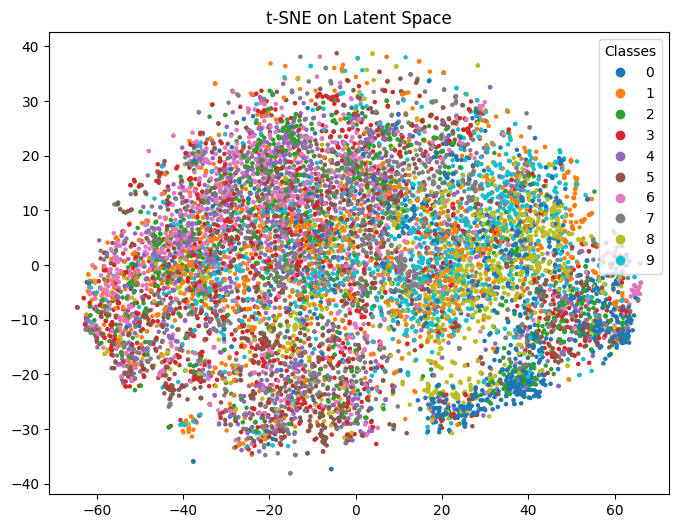

In [14]:
all_latents = []
all_labels = []

with torch.no_grad():
    for x, y in testloader:
        x = x.to(device)
        _, latent = model(x)
        latent = latent.view(latent.size(0), -1)
        all_latents.append(latent.cpu())
        all_labels.append(y)

X_latent = torch.cat(all_latents).numpy()
y_latent = torch.cat(all_labels).numpy()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_latent)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_latent, cmap='tab10', s=5)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE on Latent Space")
plt.show()


# PCA

visualize the latent space of the autoencoder using PCA, projecting it into 2D. This clean and styled plot helps in understanding how well the autoencoder clusters different CIFAR-10 classes based on their learned features.

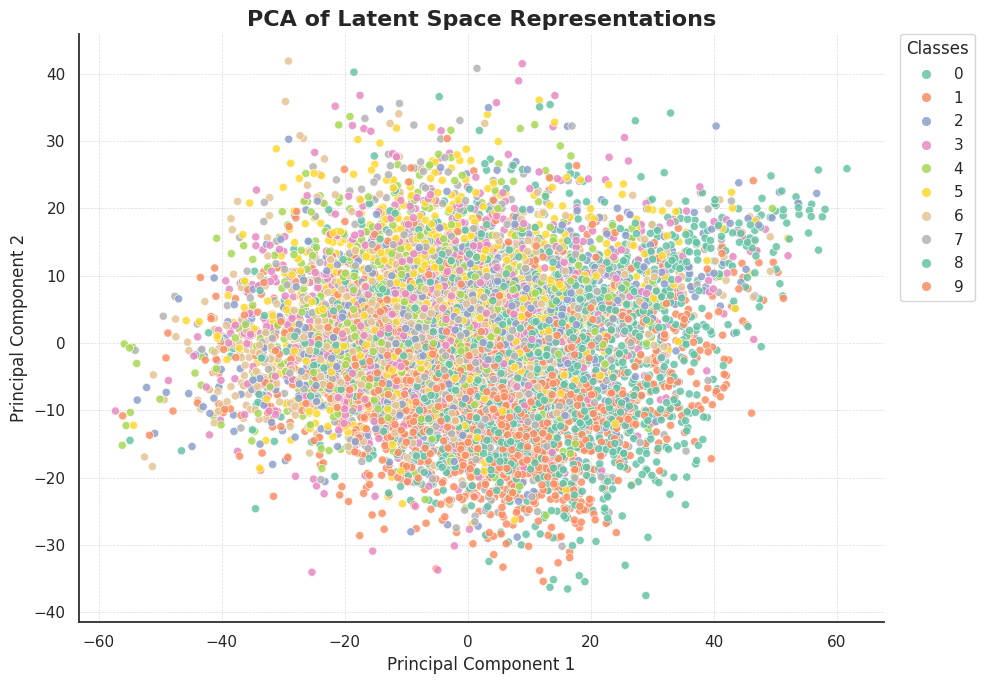

In [15]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# import seaborn as sns
# import matplotlib
# import numpy as np

# Reduce dimensionality to 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_latent)

# Set modern seaborn style
sns.set(style="white", rc={"axes.spines.right": False, "axes.spines.top": False})

# Define color palette
num_classes = len(np.unique(y_latent))
palette = sns.color_palette("Set2", num_classes)  # "tab10", "pastel", etc.

# Create plot
plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=y_latent,
    cmap=matplotlib.colors.ListedColormap(palette),
    s=35,
    alpha=0.85,
    edgecolors='white',
    linewidth=0.5
)

# Title and labels
plt.title("PCA of Latent Space Representations", fontsize=16, weight='bold')
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)

# Legend (outside the plot)
handles, labels = scatter.legend_elements(prop="colors")
plt.legend(handles, labels, title="Classes", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

# Aesthetics
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


PCA Density map

### Effectiveness of Autoencoders in Feature Learning
Unsupervised learning: No labels required to learn meaningful features.

Dimensionality reduction: Compresses data into a compact latent space.

Noise removal: Can reconstruct clean images from noisy inputs we can do it using only ae.

Semantic structure: Latent space often groups similar classes together.

Feature extraction: Latent vectors can be reused for other ML tasks.

Efficient representation: Captures essential patterns in the data.

# **Model-2 **

### An overview of our model2

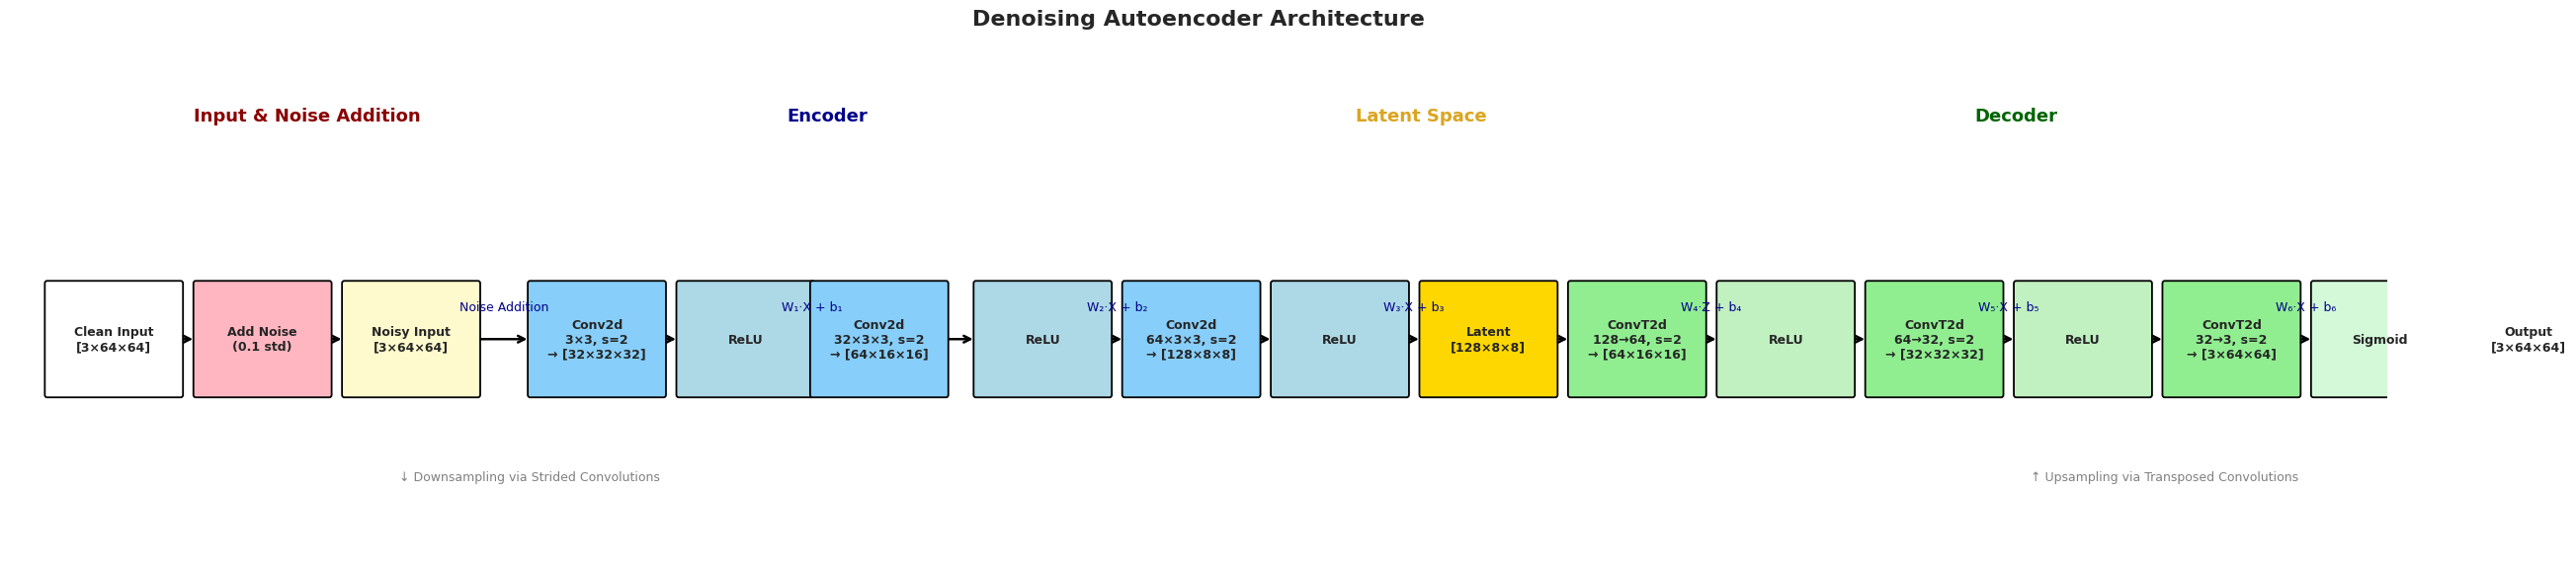

In [16]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

def draw_block(ax, x, y, w, h, label, color='lightgray'):
    rect = patches.FancyBboxPatch((x, y), w, h,
                                   boxstyle="round,pad=0.03",
                                   linewidth=1.3,
                                   edgecolor='black',
                                   facecolor=color)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, label, ha='center', va='center', fontsize=9, weight='bold')

def draw_denoising_autoencoder():
    fig, ax = plt.subplots(figsize=(26, 6))
    ax.set_xlim(0, 32)
    ax.set_ylim(0, 6)
    ax.axis('off')

    # Define each layer block: (Label, x-position, color)
    layers = [
        ("Clean Input\n[3×64×64]", 0.5, '#ffffff'),
        ("Add Noise\n(0.1 std)", 2.5, '#FFB6C1'),
        ("Noisy Input\n[3×64×64]", 4.5, '#fffacd'),
        # Encoder
        ("Conv2d\n3×3, s=2\n→ [32×32×32]", 7.0, '#87CEFA'),
        ("ReLU", 9.0, '#add8e6'),
        ("Conv2d\n32×3×3, s=2\n→ [64×16×16]", 10.8, '#87CEFA'),
        ("ReLU", 13.0, '#add8e6'),
        ("Conv2d\n64×3×3, s=2\n→ [128×8×8]", 15.0, '#87CEFA'),
        ("ReLU", 17.0, '#add8e6'),
        ("Latent\n[128×8×8]", 19.0, '#FFD700'),
        # Decoder
        ("ConvT2d\n128→64, s=2\n→ [64×16×16]", 21.0, '#90EE90'),
        ("ReLU", 23.0, '#c1f0c1'),
        ("ConvT2d\n64→32, s=2\n→ [32×32×32]", 25.0, '#90EE90'),
        ("ReLU", 27.0, '#c1f0c1'),
        ("ConvT2d\n32→3, s=2\n→ [3×64×64]", 29.0, '#90EE90'),
        ("Sigmoid", 31.0, '#d3f9d8'),
        ("Output\n[3×64×64]", 33.0, '#ffffff'),
    ]

    # Draw each block
    for label, x, color in layers:
        draw_block(ax, x, 2, 1.8, 1.3, label, color)

    # Draw arrows between blocks with optional matrix multiplication or operation labels
    # Here we show some sample labels. You can adjust or remove them if not needed.
    op_labels = [
        "", "", "Noise Addition", "", "W₁·X + b₁", "", "W₂·X + b₂", "",
        "W₃·X + b₃", "", "W₄·Z + b₄", "", "W₅·X + b₅", "", "W₆·X + b₆", "", ""
    ]

    # Create arrows between adjacent blocks
    for i in range(len(layers) - 1):
        x_start = layers[i][1] + 1.8
        x_end = layers[i+1][1]
        y = 2.65
        ax.annotate("",
                    xy=(x_end, y),
                    xytext=(x_start, y),
                    arrowprops=dict(arrowstyle="->", lw=1.8, color='black'))
        if i < len(op_labels) and op_labels[i]:
            ax.text((x_start + x_end)/2, y + 0.3, op_labels[i],
                    fontsize=9, ha='center', va='bottom', color='darkblue')

    # Section Titles for clarity
    ax.text(4.0, 5.2, "Input & Noise Addition", fontsize=13, weight='bold', ha='center', color="#8B0000")
    ax.text(11.0, 5.2, "Encoder", fontsize=13, weight='bold', ha='center', color="#00008B")
    ax.text(19.0, 5.2, "Latent Space", fontsize=13, weight='bold', ha='center', color="#DAA520")
    ax.text(27.0, 5.2, "Decoder", fontsize=13, weight='bold', ha='center', color="#006400")

    # Extra Notes (optional)
    ax.text(7.0, 1.0, "↓ Downsampling via Strided Convolutions", fontsize=9, color='gray', ha='center')
    ax.text(29.0, 1.0, "↑ Upsampling via Transposed Convolutions", fontsize=9, color='gray', ha='center')

    plt.title("Denoising Autoencoder Architecture", fontsize=16, weight='bold', pad=20)
    plt.tight_layout()
    plt.show()

draw_denoising_autoencoder()


add Gaussian noise to input tensors for testing denoising capabilities of models like denoising autoencoders, while ensuring the resulting values stay within the valid [0, 1] range.

In [17]:
def add_noise(inputs, noise_std=0.1):
    noise = torch.randn_like(inputs) * noise_std
    noisy_inputs = inputs + noise
    return torch.clip(noisy_inputs, 0., 1.)


train a denoising autoencoder (DAE) on noisy CIFAR-10 images using Gaussian noise (σ = 0.3). The model learns to reconstruct clean images from noisy inputs over 20 epochs, using MSE loss and the Adam optimizer.

In [18]:
dae_model = Autoencoder().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

noise_std = 0.3  # You can repeat for 0.1 and 0.5
dae_loss_list = []

num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs, noise_std=noise_std)
        outputs, _ = dae_model(noisy_imgs)
        loss = criterion(outputs, imgs)
        dae_optimizer.zero_grad()
        loss.backward()
        dae_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(trainloader)
    dae_loss_list.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.0204
Epoch [2/20], Loss: 0.0109
Epoch [3/20], Loss: 0.0094
Epoch [4/20], Loss: 0.0088
Epoch [5/20], Loss: 0.0084
Epoch [6/20], Loss: 0.0080
Epoch [7/20], Loss: 0.0077
Epoch [8/20], Loss: 0.0075
Epoch [9/20], Loss: 0.0074
Epoch [10/20], Loss: 0.0073
Epoch [11/20], Loss: 0.0072
Epoch [12/20], Loss: 0.0071
Epoch [13/20], Loss: 0.0070
Epoch [14/20], Loss: 0.0070
Epoch [15/20], Loss: 0.0069
Epoch [16/20], Loss: 0.0069
Epoch [17/20], Loss: 0.0068
Epoch [18/20], Loss: 0.0068
Epoch [19/20], Loss: 0.0068
Epoch [20/20], Loss: 0.0067


Compare reconstruction performance of:

Standard Autoencoder (AE)

Denoising Autoencoder (DAE)

Noise: Gaussian noise with standard deviation √0.1 ≈ 0.316 added to test images

Visual Comparison:

show_images() displays:

Noisy input vs. AE reconstruction

Noisy input vs. DAE reconstruction

Quantitative Evaluation (evaluate_metrics()):

SSIM – Structural similarity

PSNR – Peak signal-to-noise ratio

MAE – Mean absolute error

MSE – Mean squared error

Metrics are printed for both AE and DAE

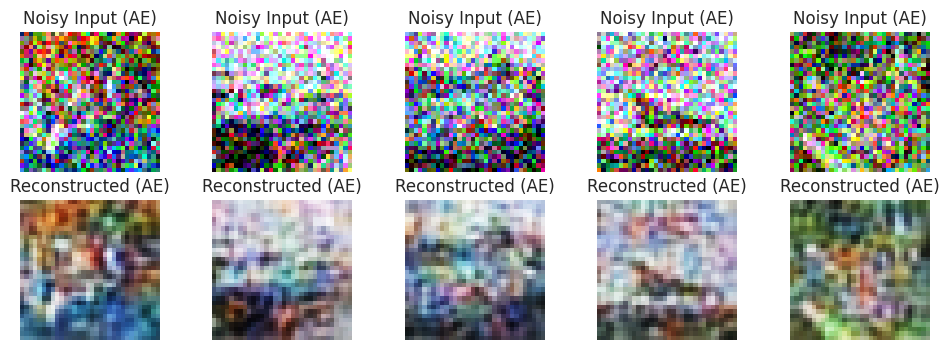

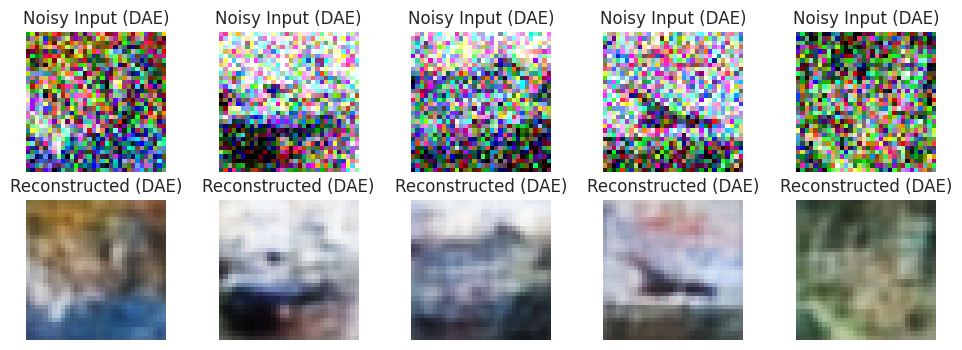

=== AE Metrics (noisy input) ===
SSIM: 0.5577
PSNR: 18.01 dB
MAE: 0.1003
MSE: 0.0159

=== DAE Metrics (noisy input) ===
SSIM: 0.6991
PSNR: 21.74 dB
MAE: 0.0640
MSE: 0.0070


In [19]:
def show_images(original, reconstructed, n=5, row_titles=["Input", "Reconstructed"]):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(np.transpose(original[i], (1, 2, 0)))
        plt.title(row_titles[0])
        plt.axis("off")
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        plt.title(row_titles[1])
        plt.axis("off")
    plt.show()

# Function to add Gaussian noise
def add_noise(images, noise_std=0.316):  # √0.1 ≈ 0.316
    noise = torch.randn_like(images) * noise_std
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

# AE with noisy input
model.eval()
with torch.no_grad():
    for data in testloader:
        clean_imgs, _ = data
        clean_imgs = clean_imgs.to(device)
        noisy_imgs = add_noise(clean_imgs, noise_std=0.316)
        recon, _ = model(noisy_imgs)
        break
show_images(noisy_imgs.cpu(), recon.cpu(), row_titles=["Noisy Input (AE)", "Reconstructed (AE)"])

# DAE with noisy input
dae_model.eval()
with torch.no_grad():
    for data in testloader:
        clean_imgs, _ = data
        clean_imgs = clean_imgs.to(device)
        noisy_imgs = add_noise(clean_imgs, noise_std=0.316)
        recon_imgs, _ = dae_model(noisy_imgs)
        break
show_images(noisy_imgs.cpu(), recon_imgs.cpu(), row_titles=["Noisy Input (DAE)", "Reconstructed (DAE)"])

# Evaluation metrics (compared to clean targets)
def evaluate_metrics(original, reconstructed):
    original = original.permute(0, 2, 3, 1).cpu().numpy()
    reconstructed = reconstructed.permute(0, 2, 3, 1).cpu().numpy()
    ssim_list, psnr_list, mae_list, mse_list = [], [], [], []
    for i in range(original.shape[0]):
        orig_img = original[i]
        recon_img = reconstructed[i]
        ssim_list.append(ssim(orig_img, recon_img, channel_axis=-1, data_range=1.0))
        psnr_list.append(psnr(orig_img, recon_img, data_range=1.0))
        mae_list.append(np.abs(orig_img - recon_img).mean())
        mse_list.append(np.square(orig_img - recon_img).mean())
    print(f"SSIM: {np.mean(ssim_list):.4f}")
    print(f"PSNR: {np.mean(psnr_list):.2f} dB")
    print(f"MAE: {np.mean(mae_list):.4f}")
    print(f"MSE: {np.mean(mse_list):.4f}")

print("=== AE Metrics (noisy input) ===")
evaluate_metrics(clean_imgs, recon)

print("\n=== DAE Metrics (noisy input) ===")
evaluate_metrics(clean_imgs, recon_imgs)


# Evaluation

In [20]:
print("=== AE Metrics ===")
evaluate_metrics(imgs, recon)
print("\n=== DAE Metrics ===")
evaluate_metrics(clean_imgs, recon_imgs)


=== AE Metrics ===
SSIM: 0.0215
PSNR: 9.50 dB
MAE: 0.2827
MSE: 0.1219

=== DAE Metrics ===
SSIM: 0.6991
PSNR: 21.74 dB
MAE: 0.0640
MSE: 0.0070


# Ploot AE vs DAE

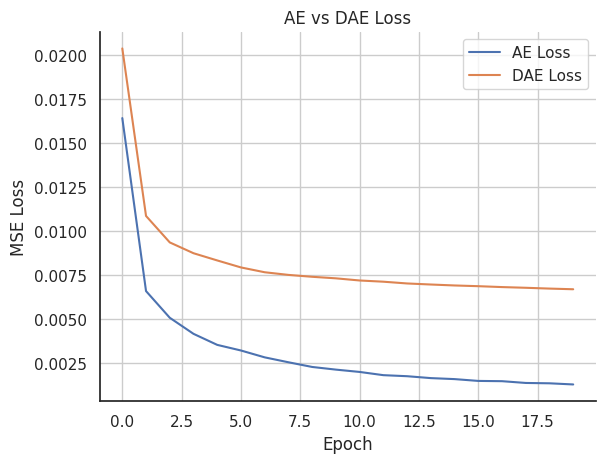

In [21]:
plt.plot(train_loss_list, label='AE Loss')
plt.plot(dae_loss_list, label='DAE Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("AE vs DAE Loss")
plt.legend()
plt.grid(True)
plt.show()


# for 0.1 noise and other noise wwe have just copy pasted the above code and used it after changing respective parameters

Epoch [1/20], Loss: 0.0165
Epoch [2/20], Loss: 0.0074
Epoch [3/20], Loss: 0.0058
Epoch [4/20], Loss: 0.0048
Epoch [5/20], Loss: 0.0042
Epoch [6/20], Loss: 0.0039
Epoch [7/20], Loss: 0.0036
Epoch [8/20], Loss: 0.0034
Epoch [9/20], Loss: 0.0033
Epoch [10/20], Loss: 0.0031
Epoch [11/20], Loss: 0.0030
Epoch [12/20], Loss: 0.0030
Epoch [13/20], Loss: 0.0029
Epoch [14/20], Loss: 0.0028
Epoch [15/20], Loss: 0.0028
Epoch [16/20], Loss: 0.0027
Epoch [17/20], Loss: 0.0027
Epoch [18/20], Loss: 0.0026
Epoch [19/20], Loss: 0.0026
Epoch [20/20], Loss: 0.0026


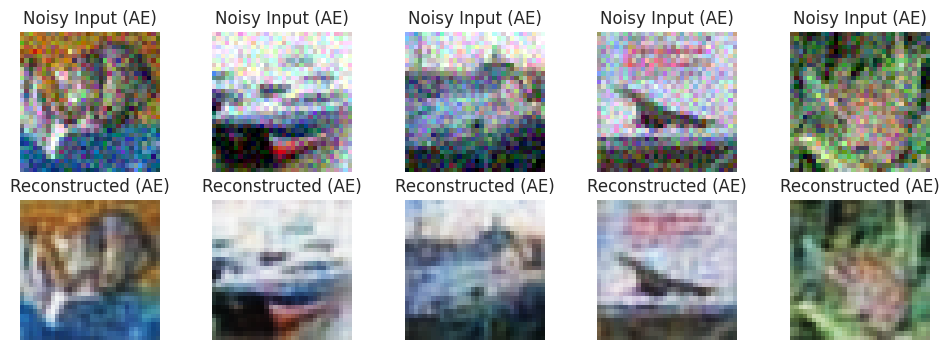

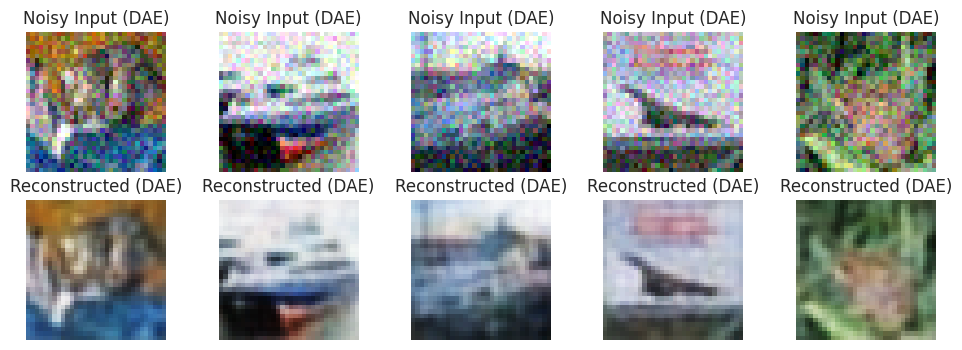

=== AE Metrics (noisy input, std = 0.1) ===
SSIM: 0.8423
PSNR: 25.23 dB
MAE: 0.0432
MSE: 0.0031

=== DAE Metrics (noisy input, std = 0.1) ===
SSIM: 0.8668
PSNR: 26.06 dB
MAE: 0.0390
MSE: 0.0027


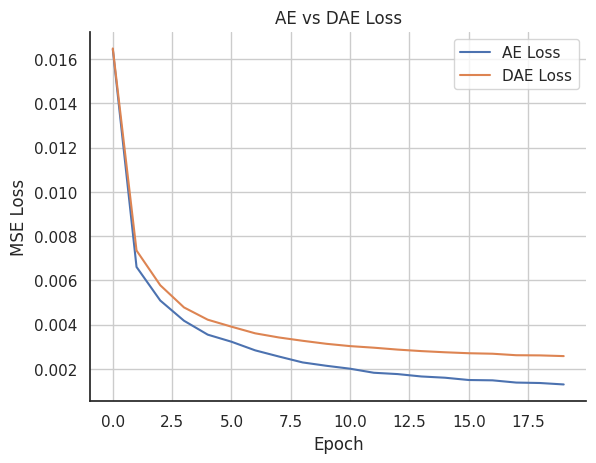

In [22]:
dae_model = Autoencoder().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

noise_std = 0.1  # You can repeat for 0.3 and 0.5
dae_loss_list = []

num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs, noise_std=noise_std)
        outputs, _ = dae_model(noisy_imgs)
        loss = criterion(outputs, imgs)
        dae_optimizer.zero_grad()
        loss.backward()
        dae_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(trainloader)
    dae_loss_list.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
def show_images(original, reconstructed, n=5, row_titles=["Input", "Reconstructed"]):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(np.transpose(original[i], (1, 2, 0)))
        plt.title(row_titles[0])
        plt.axis("off")
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        plt.title(row_titles[1])
        plt.axis("off")
    plt.show()

# Function to add Gaussian noise with std = 0.1
def add_noise(images, noise_std=0.1):
    noise = torch.randn_like(images) * noise_std
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

# AE with noisy input
model.eval()
with torch.no_grad():
    for data in testloader:
        clean_imgs, _ = data
        clean_imgs = clean_imgs.to(device)
        noisy_imgs = add_noise(clean_imgs, noise_std=0.1)
        recon, _ = model(noisy_imgs)
        break
show_images(noisy_imgs.cpu(), recon.cpu(), row_titles=["Noisy Input (AE)", "Reconstructed (AE)"])

# DAE with noisy input
dae_model.eval()
with torch.no_grad():
    for data in testloader:
        clean_imgs, _ = data
        clean_imgs = clean_imgs.to(device)
        noisy_imgs = add_noise(clean_imgs, noise_std=0.1)
        recon_imgs, _ = dae_model(noisy_imgs)
        break
show_images(noisy_imgs.cpu(), recon_imgs.cpu(), row_titles=["Noisy Input (DAE)", "Reconstructed (DAE)"])

# Evaluation metrics (compared to clean targets)
def evaluate_metrics(original, reconstructed):
    original = original.permute(0, 2, 3, 1).cpu().numpy()
    reconstructed = reconstructed.permute(0, 2, 3, 1).cpu().numpy()
    ssim_list, psnr_list, mae_list, mse_list = [], [], [], []
    for i in range(original.shape[0]):
        orig_img = original[i]
        recon_img = reconstructed[i]
        ssim_list.append(ssim(orig_img, recon_img, channel_axis=-1, data_range=1.0))
        psnr_list.append(psnr(orig_img, recon_img, data_range=1.0))
        mae_list.append(np.abs(orig_img - recon_img).mean())
        mse_list.append(np.square(orig_img - recon_img).mean())
    print(f"SSIM: {np.mean(ssim_list):.4f}")
    print(f"PSNR: {np.mean(psnr_list):.2f} dB")
    print(f"MAE: {np.mean(mae_list):.4f}")
    print(f"MSE: {np.mean(mse_list):.4f}")

print("=== AE Metrics (noisy input, std = 0.1) ===")
evaluate_metrics(clean_imgs, recon)

print("\n=== DAE Metrics (noisy input, std = 0.1) ===")
evaluate_metrics(clean_imgs, recon_imgs)
plt.plot(train_loss_list, label='AE Loss')
plt.plot(dae_loss_list, label='DAE Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("AE vs DAE Loss")
plt.legend()
plt.grid(True)
plt.show()




noise 0.5

Epoch [1/20], Loss: 0.0190
Epoch [2/20], Loss: 0.0124
Epoch [3/20], Loss: 0.0116
Epoch [4/20], Loss: 0.0112
Epoch [5/20], Loss: 0.0109
Epoch [6/20], Loss: 0.0108
Epoch [7/20], Loss: 0.0107
Epoch [8/20], Loss: 0.0106
Epoch [9/20], Loss: 0.0106
Epoch [10/20], Loss: 0.0105
Epoch [11/20], Loss: 0.0105
Epoch [12/20], Loss: 0.0105
Epoch [13/20], Loss: 0.0105
Epoch [14/20], Loss: 0.0104
Epoch [15/20], Loss: 0.0104
Epoch [16/20], Loss: 0.0104
Epoch [17/20], Loss: 0.0103
Epoch [18/20], Loss: 0.0104
Epoch [19/20], Loss: 0.0103
Epoch [20/20], Loss: 0.0103


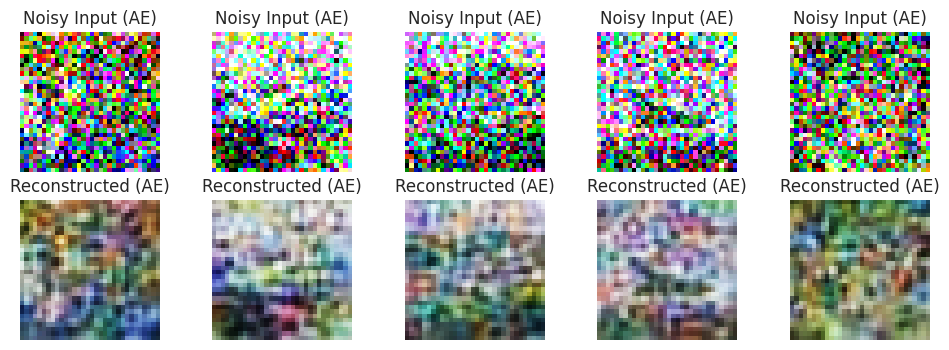

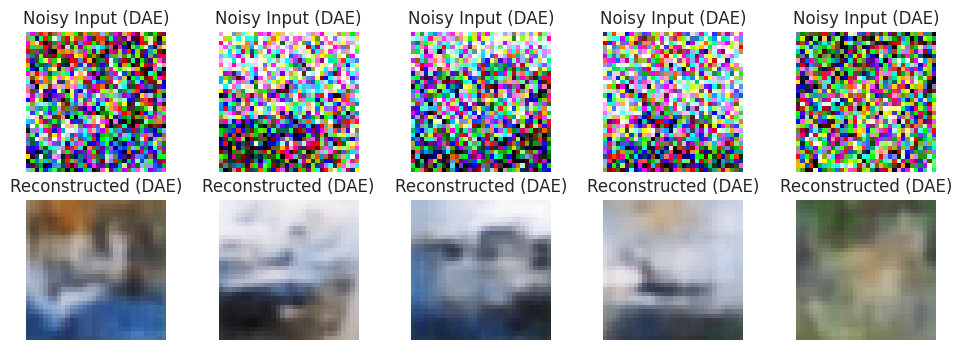

=== AE Metrics (noisy input, std = 0.5) ===
SSIM: 0.4063
PSNR: 15.25 dB
MAE: 0.1383
MSE: 0.0301

=== DAE Metrics (noisy input, std = 0.5) ===
SSIM: 0.6001
PSNR: 19.99 dB
MAE: 0.0780
MSE: 0.0106


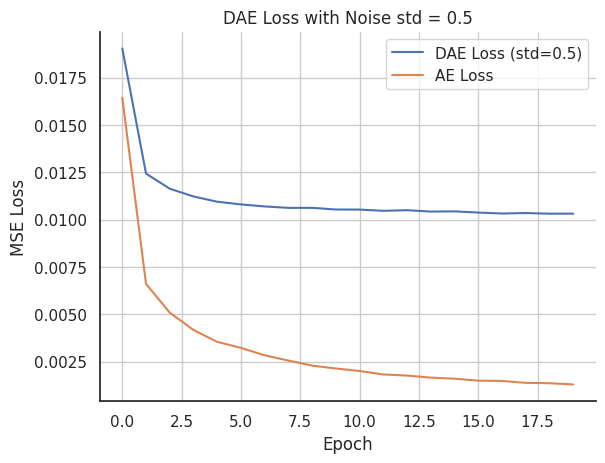

In [23]:
dae_model = Autoencoder().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

noise_std = 0.5  # Increased noise
dae_loss_list = []

num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs, noise_std=noise_std)
        outputs, _ = dae_model(noisy_imgs)
        loss = criterion(outputs, imgs)
        dae_optimizer.zero_grad()
        loss.backward()
        dae_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(trainloader)
    dae_loss_list.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Show images
def show_images(original, reconstructed, n=5, row_titles=["Input", "Reconstructed"]):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(np.transpose(original[i], (1, 2, 0)))
        plt.title(row_titles[0])
        plt.axis("off")
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        plt.title(row_titles[1])
        plt.axis("off")
    plt.show()

# Function to add Gaussian noise with std = 0.5
def add_noise(images, noise_std=0.5):
    noise = torch.randn_like(images) * noise_std
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

# AE with noisy input
model.eval()
with torch.no_grad():
    for data in testloader:
        clean_imgs, _ = data
        clean_imgs = clean_imgs.to(device)
        noisy_imgs = add_noise(clean_imgs, noise_std=0.5)
        recon, _ = model(noisy_imgs)
        break
show_images(noisy_imgs.cpu(), recon.cpu(), row_titles=["Noisy Input (AE)", "Reconstructed (AE)"])

# DAE with noisy input
dae_model.eval()
with torch.no_grad():
    for data in testloader:
        clean_imgs, _ = data
        clean_imgs = clean_imgs.to(device)
        noisy_imgs = add_noise(clean_imgs, noise_std=0.5)
        recon_imgs, _ = dae_model(noisy_imgs)
        break
show_images(noisy_imgs.cpu(), recon_imgs.cpu(), row_titles=["Noisy Input (DAE)", "Reconstructed (DAE)"])

# Evaluation metrics (compared to clean targets)
def evaluate_metrics(original, reconstructed):
    original = original.permute(0, 2, 3, 1).cpu().numpy()
    reconstructed = reconstructed.permute(0, 2, 3, 1).cpu().numpy()
    ssim_list, psnr_list, mae_list, mse_list = [], [], [], []
    for i in range(original.shape[0]):
        orig_img = original[i]
        recon_img = reconstructed[i]
        ssim_list.append(ssim(orig_img, recon_img, channel_axis=-1, data_range=1.0))
        psnr_list.append(psnr(orig_img, recon_img, data_range=1.0))
        mae_list.append(np.abs(orig_img - recon_img).mean())
        mse_list.append(np.square(orig_img - recon_img).mean())
    print(f"SSIM: {np.mean(ssim_list):.4f}")
    print(f"PSNR: {np.mean(psnr_list):.2f} dB")
    print(f"MAE: {np.mean(mae_list):.4f}")
    print(f"MSE: {np.mean(mse_list):.4f}")

print("=== AE Metrics (noisy input, std = 0.5) ===")
evaluate_metrics(clean_imgs, recon)

print("\n=== DAE Metrics (noisy input, std = 0.5) ===")
evaluate_metrics(clean_imgs, recon_imgs)

# Plot losses (you can add `train_loss_list` if you trained AE too)
plt.plot(dae_loss_list, label='DAE Loss (std=0.5)')
plt.plot(train_loss_list, label='AE Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("DAE Loss with Noise std = 0.5")
plt.legend()
plt.grid(True)
plt.show()


# classification accuracy to test feature learnability

 I was having some naming issues hence I wrote some functions again -> note it is training on noisy data

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Helper: add Gaussian noise ----
def add_noise(images, noise_std=0.5):
    noise = torch.randn_like(images) * noise_std
    return torch.clamp(images + noise, 0., 1.)

# ---- Classifier wrapper around an encoder ----
class EncoderClassifier(nn.Module):
    def __init__(self, encoder, latent_dim=128*4*4, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # freeze encoder
        with torch.no_grad():
            latent = self.encoder(x)
        return self.classifier(latent)

# ---- Training on CLEAN data ----
def train_classifier_clean(model, optimizer, criterion, loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total, correct, loss_sum = 0, 0, 0.0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)                 # clean input
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}/{epochs} — "
              f"Loss: {loss_sum/total:.4f}, "
              f"Acc: {100*correct/total:.2f}%")

# ---- Evaluation on NOISY data ----
def evaluate_noisy(model, loader, noise_std=0.5):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            noisy = add_noise(imgs, noise_std)   # noisy input
            outputs = model(noisy)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# ---- Instantiate classifiers (swapped names) ----
dae_clf = EncoderClassifier(model.encoder).to(device)        # was ae_clf
ae_clf  = EncoderClassifier(dae_model.encoder).to(device)   # was dae_clf

criterion = nn.CrossEntropyLoss()
dae_opt = optim.Adam(dae_clf.classifier.parameters(), lr=1e-3)  # was ae_opt
ae_opt  = optim.Adam(ae_clf.classifier.parameters(),  lr=1e-3)  # was dae_opt

# ---- Train heads on CLEAN data (swapped) ----
print("Training DAE-based classifier on:")
train_classifier_clean(dae_clf, dae_opt, criterion, trainloader, epochs=10)

print("\nTraining AE-based classifier on:")
train_classifier_clean(ae_clf, ae_opt, criterion, trainloader, epochs=10)

# ---- Final evaluation on NOISY data (swapped) ----
dae_acc = evaluate_noisy(dae_clf, testloader, noise_std=0.5)
ae_acc  = evaluate_noisy(ae_clf,  testloader, noise_std=0.5)

print("\nFinal Test Accuracy:")
print(f"  DAE Classifier: {dae_acc:.2f}%")
print(f"  AE Classifier : {ae_acc:.2f}%")


Training DAE-based classifier on CLEAN data:
Epoch 1/10 — Loss: 1.9544, Acc: 30.08%
Epoch 2/10 — Loss: 1.7532, Acc: 37.68%
Epoch 3/10 — Loss: 1.6873, Acc: 39.79%
Epoch 4/10 — Loss: 1.6382, Acc: 41.55%
Epoch 5/10 — Loss: 1.6059, Acc: 42.43%
Epoch 6/10 — Loss: 1.5847, Acc: 43.52%
Epoch 7/10 — Loss: 1.5598, Acc: 44.29%
Epoch 8/10 — Loss: 1.5422, Acc: 44.82%
Epoch 9/10 — Loss: 1.5267, Acc: 45.47%
Epoch 10/10 — Loss: 1.5139, Acc: 46.05%

Training AE-based classifier on CLEAN data:
Epoch 1/10 — Loss: 2.0186, Acc: 27.35%
Epoch 2/10 — Loss: 1.8138, Acc: 35.59%
Epoch 3/10 — Loss: 1.7239, Acc: 38.72%
Epoch 4/10 — Loss: 1.6573, Acc: 41.11%
Epoch 5/10 — Loss: 1.6103, Acc: 42.72%
Epoch 6/10 — Loss: 1.5764, Acc: 44.17%
Epoch 7/10 — Loss: 1.5477, Acc: 44.98%
Epoch 8/10 — Loss: 1.5215, Acc: 46.00%
Epoch 9/10 — Loss: 1.5003, Acc: 46.72%
Epoch 10/10 — Loss: 1.4827, Acc: 47.24%

Final Test Accuracy:
  DAE Classifier: 35.57%
  AE Classifier : 14.24%
